In [1]:
import os

import numpy as np
import pickle

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from utils import STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH
from analyses.ridge_regression_decoding import Standardize, get_distance_matrix, \
    dist_mat_to_pairwise_acc, get_fmri_data_paths, get_nn_latent_data

from feature_extraction.feat_extraction_utils import CoCoDataset
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange
from preprocessing.create_gray_matter_masks import get_graymatter_mask_path
import nibabel

# Nearest Neighbors of test images

In [2]:
from utils import FMRI_DATA_DIR

SUBJECT = 'sub-01'
MODEL = "imagebind"
STIM_TYPE = 'image'
BETAS_DIR = os.path.join(FMRI_DATA_DIR, 'betas_backup')
train_paths, stim_ids, stim_types = get_fmri_data_paths(BETAS_DIR, SUBJECT, "train_image")

latents, _ = get_nn_latent_data(MODEL, 'avg',
                                'vision_features_cls',
                                'lang_features_cls',
                                stim_ids,
                                stim_types,
                                SUBJECT,
                                "train"
                                )

train_paths = np.array(train_paths)[stim_types == STIM_TYPE]

/home/mitja/code/multimodal_decoding/analyses/ridge_regression_decoding.py:189: RuntimeWarning: Mean of empty slice.
  'mean': nn_latent_vectors[stim_types == CAPTION].mean(axis=0),
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [3]:
gray_matter_mask_path = get_graymatter_mask_path(SUBJECT)
gray_matter_mask_img = nibabel.load(gray_matter_mask_path)
gray_matter_mask_data = gray_matter_mask_img.get_fdata()
gray_matter_mask = gray_matter_mask_data == 1
print(f"Gray matter mask size: {gray_matter_mask.sum()}")

fmri_train_betas = []
for idx in trange(len(train_paths), desc="loading fmri data"):
    sample = nibabel.load(train_paths[idx])
    sample = sample.get_fdata()
    sample = sample[gray_matter_mask].astype('float32').reshape(-1)
    fmri_train_betas.append(sample)

fmri_train_betas = np.array(fmri_train_betas)


Gray matter mask size: 162649


loading fmri data: 100%|██████████| 4928/4928 [03:24<00:00, 24.05it/s]


In [4]:
test_paths, test_stim_ids, test_stim_types = get_fmri_data_paths(BETAS_DIR, SUBJECT, "test")
test_paths = np.array(test_paths)[test_stim_types == STIM_TYPE]
test_stim_ids = test_stim_ids[test_stim_types == STIM_TYPE]
test_paths.shape

(70,)

In [5]:
fmri_test_betas = []
for idx in trange(len(test_paths), desc="loading fmri data"):
    sample = nibabel.load(test_paths[idx])
    sample = sample.get_fdata()
    sample = sample[gray_matter_mask].astype('float32').reshape(-1)
    fmri_test_betas.append(sample)

fmri_test_betas = np.array(fmri_test_betas)


loading fmri data: 100%|██████████| 70/70 [00:03<00:00, 22.78it/s]


In [ ]:
train_test = np.concatenate((fmri_test_betas, fmri_train_betas))
tsne = TSNE(n_components=2, learning_rate='auto', verbose=1, n_jobs=10, max_iter=1000)
X_embedded = tsne.fit_transform(train_test)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4998 samples in 0.210s...


In [12]:
# pca = PCA(n_components=2)
# X_embedded_pca = pca.fit_transform(train_test)

# train_hues = ['g' for i in range(len(fmri_train_betas))] #if i in outliers else 'b'
# hue = ['r'] * len(fmri_test_betas) + train_hues
# alpha = [1] * len(fmri_test_betas) + [0.1] * len(fmri_train_betas)
# 
# plt.figure(figsize=(20, 12))
# sns.scatterplot(
#     x = X_embedded_pca[:, 0], y = X_embedded_pca[:, 1],
#     hue = hue,
#     # palette = sns.color_palette("hls", 10),
#     legend = "full",
#     alpha = alpha
# )

In [11]:
X_embedded_train = X_embedded[len(fmri_test_betas):]
outlier_thresh = 25
outliers = np.argwhere((X_embedded_train[:,0] > outlier_thresh) | (X_embedded_train[:,0] < -outlier_thresh) | (X_embedded_train[:,1] < -outlier_thresh) | (X_embedded_train[:,1] > outlier_thresh)) 
outliers = outliers.flatten()
len(outliers)
# pickle.dump(outliers, open('outliers.p', 'wb'))

1368

(4998, 2)


<Axes: >

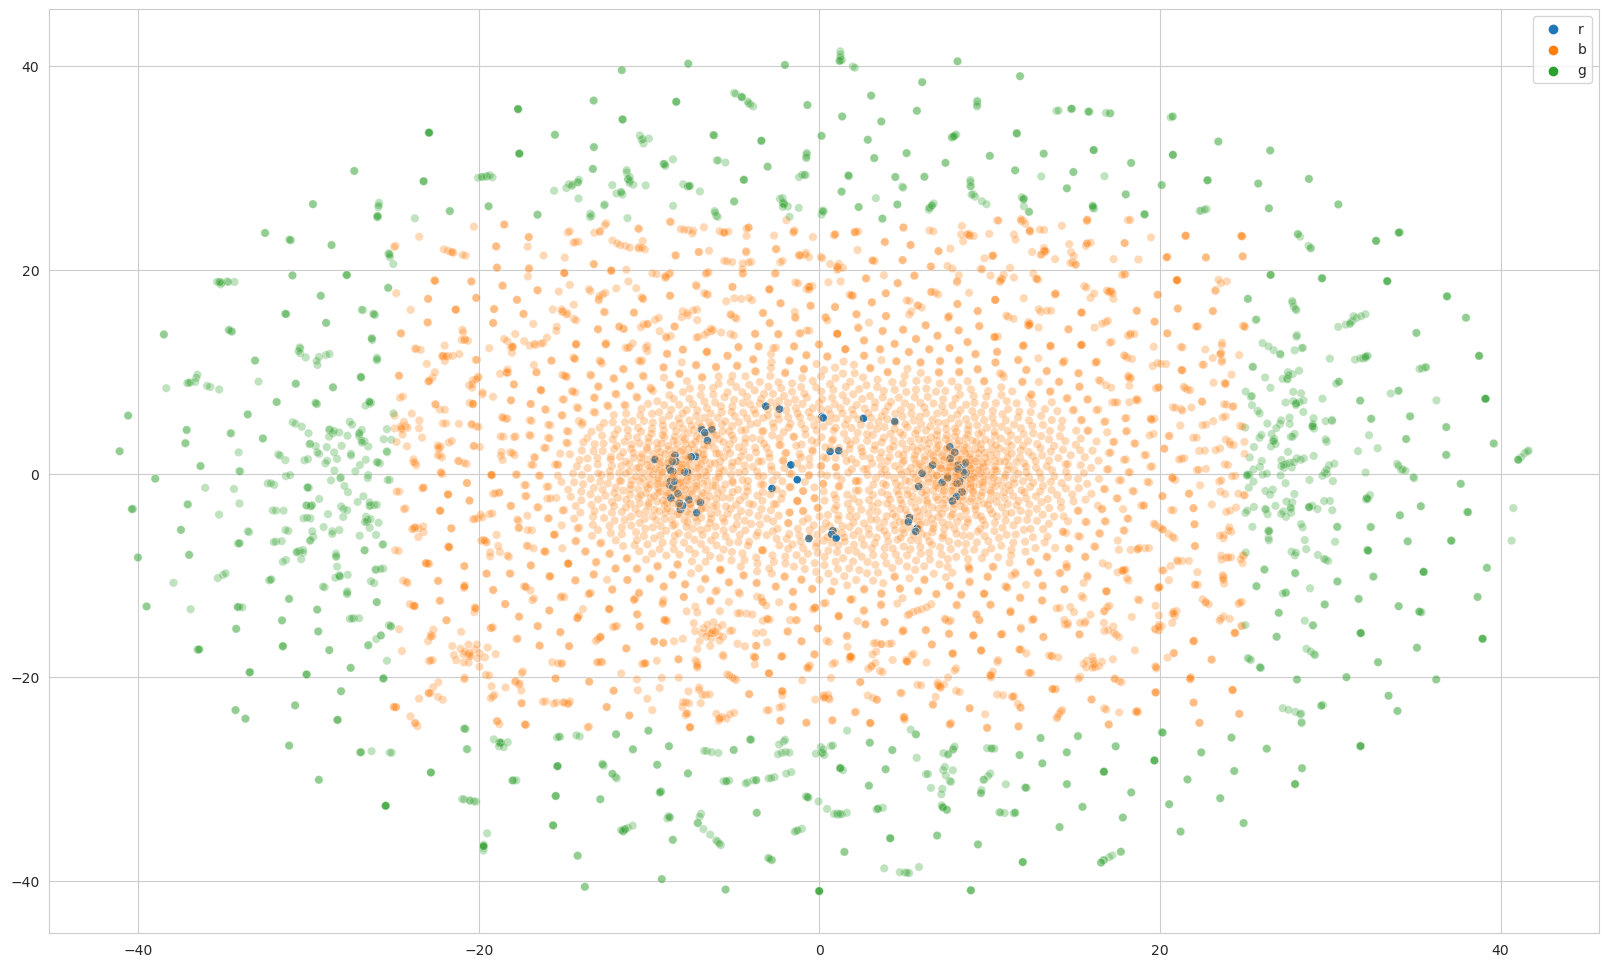

In [13]:
print(X_embedded.shape)
assert X_embedded.shape[1] == 2
train_hues = ['g' if i in outliers else 'b' for i in range(len(fmri_train_betas))]
hue = ['r'] * len(fmri_test_betas) + train_hues
alpha = [1] * len(fmri_test_betas) + [0.3] * len(fmri_train_betas)

plt.figure(figsize=(20, 12))
sns.scatterplot(
    x = X_embedded[:, 0], y = X_embedded[:, 1],
    hue = hue,
    # palette = sns.color_palette("hls", 10),
    legend = "full",
    alpha = alpha
)

In [18]:

# targets = pickle.load(open('/home/mitja/Downloads/targets.p', 'rb'))[test_stim_types == STIM_TYPE]
# preds = pickle.load(open('/home/mitja/Downloads/preds.p', 'rb'))[test_stim_types == STIM_TYPE]
# print(targets.shape)
# print(preds.shape)


In [8]:
results = pickle.load(open(
    '/home/mitja/data/multimodal_decoding/whole_brain_decoding/train_image/sub-01/imagebind_avg_test_avg_vision_features_cls_lang_features_cls/results.p',
    'rb'))
preds = results['predictions'][test_stim_types == STIM_TYPE]
targets = results['latents'][test_stim_types == STIM_TYPE]

print(targets.shape)
print(preds.shape)



(70, 1024)
(70, 1024)


In [118]:
preds.std(axis=0)
targets.std(axis=0)
preds

array([[-0.1686881 , -0.1542864 ,  0.09736352, ...,  0.02935979,
        -0.0108417 ,  0.02150932],
       [-0.1688038 , -0.1545102 ,  0.09872087, ...,  0.02906288,
        -0.0094679 ,  0.0264783 ],
       [-0.16769223, -0.1503527 ,  0.0964566 , ...,  0.02282928,
        -0.00977872,  0.0202255 ],
       ...,
       [-0.16739437, -0.15176518,  0.09539504, ...,  0.02408027,
        -0.00803183,  0.02203749],
       [-0.16762719, -0.15626425,  0.10063498, ...,  0.02808603,
        -0.00917706,  0.02516621],
       [-0.1643554 , -0.15539293,  0.09270857, ...,  0.03532567,
        -0.00753951,  0.02111856]], dtype=float32)

In [ ]:
from analyses.ridge_regression_decoding import load_latents_transform

nn_latent_transform = load_latents_transform(
    SUBJECT, MODEL, 'avg', 'vision_features_cls',
    'lang_features_cls', 'train_image'
    )
nn_latent_transform['image']

In [ ]:
train_preds_transform = Standardize(train_preds.mean(axis=0), train_preds.std(axis=0))
train_preds_transform.std

In [ ]:
concat_preds = np.concatenate((train_preds, preds), axis=0)
print(concat_preds.shape)
concat_preds_transform = Standardize(concat_preds.mean(axis=0), concat_preds.std(axis=0))
train_preds_transform.std

In [ ]:
preds_transformed = concat_preds_transform(preds)
print(preds_transformed.shape)
preds_transformed.std(axis=0)

In [ ]:
nn_latent_transform['image'](preds)


In [120]:
def display_stimuli(coco_ids):
    # print(coco_ids)
    for coco_id in coco_ids:
        print(coco_ds.captions[coco_id], end="\n")


coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH, 'caption')

In [ ]:
display_stimuli([139])

In [26]:
test_stim_ids.shape

(70,)

## With predictions averaged over all subjects:

In [124]:
NUM_SAMPLES = 5
N_NEIGHBORS = 5
# training_mode = 'modality-agnostic'
training_mode = 'images'

print(f"fMRI stimulus modality: {STIM_TYPE}")
# for subject in SUBJECTS:
# df_subj = df[df.subject == subject]
# 
# test_predictions = df_subj[df_subj.metric == "predictions"].value.item()
# test_latents = df_subj[df_subj.metric == "latents"].value.item()
# test_stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
# stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()
# 
# test_latents = test_latents[stimulus_types == stimulus_type]
# test_stimulus_ids = test_stimulus_ids[stimulus_types == stimulus_type]
# test_predictions = test_predictions[stimulus_types == stimulus_type]

candidate_set_latents = targets
candidate_set_latents_ids = test_stim_ids

test_predictions = preds
preds_standardize = Standardize(test_predictions.mean(axis=0), test_predictions.std(axis=0))
test_predictions = preds_standardize(test_predictions)

# all_test_predictions.append(test_predictions)

# test_predictions_averaged = np.mean(all_test_predictions, axis=0)

# candidate_set_latents = np.concatenate((latents, targets))
# candidate_set_latents_ids = np.concatenate((stim_ids, test_stim_ids))

dist_mat = get_distance_matrix(test_predictions, candidate_set_latents)
acc = dist_mat_to_pairwise_acc(dist_mat)
print(f"Pairwise acc: {acc:.2f}")
np.random.seed(7)
sampled_ids = np.random.choice(range(len(test_stim_ids)), NUM_SAMPLES, replace=False)
test_stimulus_ids = test_stim_ids[sampled_ids]
dist_mat = dist_mat[sampled_ids]

for test_stimulus_id, nneighbors_row in zip(test_stimulus_ids, dist_mat):
    print(f"test stimulus: {test_stimulus_id}")
    display_stimuli([test_stimulus_id])
    # if STIM_TYPE == CAPTION:
    #     print(coco_ds.get_stimuli_by_coco_id(test_stimulus_id)[1])
    # else:
    #     img = coco_ds.get_img_by_coco_id(test_stimulus_id)
    #     new_width  = 400
    #     new_height = round(new_width * img.height / img.width)
    #     display(img.resize((new_width, new_height)))
    target_location = np.argwhere(candidate_set_latents_ids == test_stimulus_id)[0][0]
    nneighbors_ids = candidate_set_latents_ids[np.argsort(nneighbors_row)]
    rank = np.argwhere(nneighbors_ids == test_stimulus_id)[0][0]
    # all_ranks.append(rank)
    # display(f"distance to target: {nneighbors_row[target_location]:.3f} | rank: {rank} of {len(nneighbors_row)}")
    # display(f"nearest neighbors distances: {np.sort(nneighbors_row)[:10]}")
    print("nearest neighbors: ")

    display_stimuli(nneighbors_ids[:N_NEIGHBORS])
    print("\n")

# print(f"mean rank: {np.mean(all_ranks)}")


fMRI stimulus modality: image
Pairwise acc: 0.95
test stimulus: 163240
A train coming up the tracks through trees
nearest neighbors: 
A train coming up the tracks through trees
a close up of a piece of cake on a plate
A lot of cars driving on a packed highway
An old school bus is parked in a field
a jet plane is parked out on a runway


test stimulus: 16764
A small dog standing inside a car
nearest neighbors: 
These two dogs sit on a bench together
A cat sits on top of a desk
A young boy holding onto a parking meter
a cat sitting in a bathroom sink
a woman holds a bundle of bananas


test stimulus: 450719
A giraffe drinking water from a man-made pond
nearest neighbors: 
a cat sitting in a bathroom sink
A teenager surfing a wave in an ocean
A snow boarder is in the air over the snow
A man that is on a skateboard on a ledge
a bowl of food in an open microwave


test stimulus: 195406
The teddy bear has a big bright red bow
nearest neighbors: 
a cat sitting in a bathroom sink
These two dog

## Per-subject: